<a target="_blank" href="https://colab.research.google.com/github/eldanc/mlbootcamp2025/blob/main/lab_4_1_gnn.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# UofT DSI-CARTE ML Bootcamp
#### June 12th, 2025
#### Graph Neural Networks - Lab 1, Day 4
#### Teaching team: Eldan Cohen, Nakul Upadhya, Alex Olson
##### Lab author: Nakul Upadhya & Pytorch Geometric Team

Recently, deep learning on graphs has emerged to one of the hottest research fields in the deep learning community.
Here, **Graph Neural Networks (GNNs)** aim to generalize classical deep learning concepts to irregular structured data (in contrast to images or texts) and to enable neural networks to reason about objects and their relations.

This tutorial will introduce you to some fundamental concepts regarding deep learning on graphs via Graph Neural Networks based on the **[PyTorch Geometric (PyG) library](https://github.com/rusty1s/pytorch_geometric)**.
PyTorch Geometric is an extension library to the popular deep learning framework [PyTorch](https://pytorch.org/), and consists of various methods and utilities to ease the implementation of Graph Neural Networks.


Lets first start by installing and importing relevant packages:

In [ ]:
!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

In [14]:
# Install required packages.
import os
import torch
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


## Graphs

A Graph is a collection of **nodes (vertices)** along with identified pairs of nodes (called **edges, links, etc**).

### Types of Graphs

Graphs can be sorted into two distinct types based on the nature of the edges in the graph.

The first one is an **Undirected Graphs**. When two nodes are connected in an undirected graph, there is no hierarchy between them. Saying A is connected to B is the same B is connected to A. One example could be a social network of friends (Saying Paul and Anna are friends is the same as saying Anna and Paul are friends). More formally: if $(a,b) = (b,a)$.


Below we use `networkx`, a python package for working with graphs, to create an example:

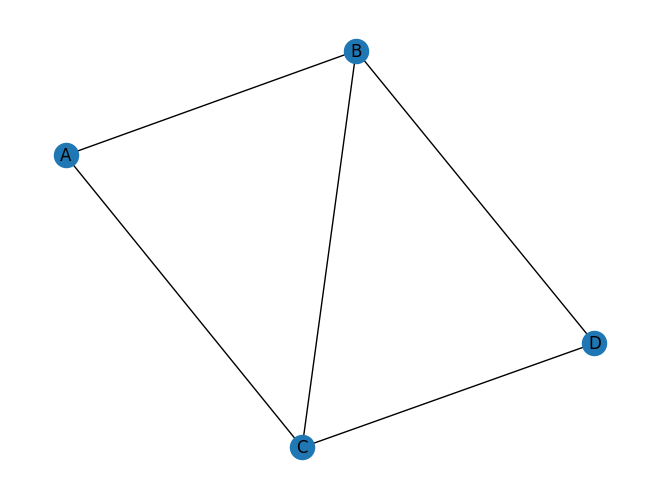

In [15]:
G = nx.Graph() # create an empty graph

G.add_node("A") # add a node called "A"
G.add_node("B")
G.add_node("C")
G.add_node("D")

G.add_edge("A", "B") # First node, 2nd node
G.add_edge("A", "C")
G.add_edge("B", "C")
G.add_edge("B", "D")
G.add_edge("C", "D")

nx.draw(G, with_labels=True) # print the graph


The other type of graph is a **Directed Graph** (aka a DiGraph). When two nodes are connected in a DiGraph, this connection is one-way. For example, think of Instagram followers. Paul can follow Anna, but Anna might not follow Paul. More formally, $(a,b) \neq (b,a)$. We can consider undirected graphs as a special case of DiGraphs where we have two

Below we create and draw a DiGraph:




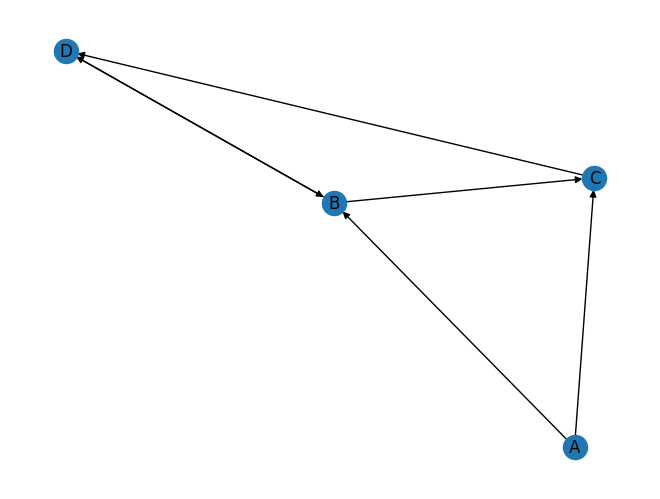

In [17]:
G = nx.DiGraph() # create an empty graph

G.add_node("A") # add a node called "A"
G.add_node("B")
G.add_node("C")
G.add_node("D")

G.add_edge("A", "B") # start of edge, end of edge
G.add_edge("A", "C")
G.add_edge("B", "C")
G.add_edge("B", "D")
G.add_edge("D", "B")
G.add_edge("C", "D")

nx.draw(G, with_labels=True) # print the graph


Notice how the edges now have arrows indicating the direction.



### Node Attributes
One quality of graphs is that each node can have information associated with it. We call these *node attributes* or *node features.* For example, each node in a graph representing a social media site (e.x. users of Facebook) can have features such as age, gender, interests, etc.



## Graph Neural Networks
GNNs operate through a **neural message passing scheme**, where node features $\mathbf{x}_v^{(\ell)}$ of all nodes $v \in \mathcal{V}$ in a graph $\mathcal{G} = (\mathcal{V}, \mathcal{E})$ are iteratively updated by aggregating  information from their neighbors $\mathcal{N}(v)$:

$$
\mathbf{x}_v^{(\ell + 1)} = f^{(\ell + 1)}_{\theta} \left( \mathbf{x}_v^{(\ell)}, \left\{ \mathbf{x}_w^{(\ell)} : w \in \mathcal{N}(v) \right\} \right)
$$



To demonstrate, we make use of the `Cora` dataset, which is a **citation network** where nodes represent documents.
Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).

This dataset was first introduced by [Yang et al. (2016)](https://arxiv.org/abs/1603.08861) as one of the datasets of the `Planetoid` benchmark suite.
We again can make use [PyTorch Geometric](https://github.com/rusty1s/pytorch_geometric) for an easy access to this dataset via [`torch_geometric.datasets.Planetoid`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.Planetoid):

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())
data = dataset[0]  # Planetoid contains a lot of graphs. We just want the first one, which is the Cora dataset


We can get information about the dataset by printing `data`

In [ ]:
print(data)

The `data` object contains various attributes:
1. `x`: This is the matrix that represents the node features. Each row is a node in the graph, and each column is a feature. In this context, the features here are the presence of words in the academic paper.
2. `y`: This is the label vector
3. `edge_index`: PyG stores the structure of the graph by saving the *edge indexes*. For each edge, `edge_index` holds a tuple of two node indices, where the first value describes the node index of the source node and the second value describes the node index of the destination node of an edge.
4. `train_mask`/`val_mask`/`test_mask`: Since the Cora dataset is often used as a benchmark, the developers have marked what nodes should be in the training/validation/test datsets.

---

**Your Turn**
* How many nodes are there in this graph?
* How many edges are there?

---


PyG stores the graph in what is known as the **COO format (coordinate format)** commonly used for representing sparse matrices.
Instead of holding the adjacency information in a dense representation $\mathbf{A} \in \{ 0, 1 \}^{|\mathcal{V}| \times |\mathcal{V}|}$, PyG represents graphs sparsely, which refers to only holding the coordinates/values for which entries in $\mathbf{A}$ are non-zero.

Importantly, *PyG does not distinguish between directed and undirected graphs*, and treats undirected graphs as a special case of directed graphs in which reverse edges exist for every entry in `edge_index`.



By printing `edge_index`, we can see this representation

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t()) # .t() transposes the tensor so each edge is a row.

## Treating the graph as Tabular Data

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)

Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Now let us define our data loaders



In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_tabular_features = data.x[data.train_mask]
test_tabular_features = data.x[data.test_mask]

train_tabular_label = data.y[data.train_mask]
test_tabular_label = data.y[data.test_mask]


train_loader = DataLoader(TensorDataset(train_tabular_features, train_tabular_label), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(test_tabular_features, test_tabular_label), batch_size=32, shuffle=False)


Let's train our simple MLP by making use of the **cross entropy loss** and **Adam optimizer**. We will also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.


epochs = 200
iterations = 0
for epoch in range(epochs):
  for batch_idx, (x, y) in enumerate(train_loader):
    model.train()
    model.zero_grad()
    out = model(x)
    loss = criterion(out,y)
    loss.backward()
    optimizer.step()
  if epoch % 25 == 0:
    with torch.no_grad():
      model.eval()
      correct = 0
      for x, y in test_loader:
        out = model(x)
        pred = out.argmax(dim=1)
        correct += int((pred == y).sum())

      test_acc = correct / len(test_loader.dataset)
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

---

**Your Turn:**

The model performed badly, with only a 60% accuracy. What are potential reasons for this poor performance given what you know about the type of data we are working with?

---

## Implementing Graph Neural Networks

After learning about PyG's data handling, it's time to implement our first Graph Neural Network!

For this, we will use on of the most simple GNN operators, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge. We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.


PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in **both** the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [ ]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, dataset.num_classes)
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.relu()
        h = self.conv2(h, edge_index)
        h = h.relu() # h is the embedding before the linear layer
        out = self.lin(h)
        return out, h


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **two graph convolution layers**, which corresponds to aggregating 2-hop neighborhood information around each node (**all nodes up to 2 "hops" away**).

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 7 classes.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.




### Training on the Graph


Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).

After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.


#### Dataloaders
Compared to tabular data, graph data requires a different type of dataloader: the `NeighborLoader` which loads in nodes AND the neighbors of that node.

If we simply use the normal dataloader for a graph neural network, we may lose information about the graph by accidentally dropping nodes.

Lets create our training and testing neighbor loaders now.


In [ ]:
from torch_geometric.loader import NeighborLoader

train_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    input_nodes=data.train_mask,
)
test_loader = NeighborLoader(
    data,
    # Sample 30 neighbors for each node for 2 iterations
    num_neighbors=[30] * 2,
    # Use a batch size of 128 for sampling training nodes
    batch_size=128,
    input_nodes=data.test_mask,
)

---

**Your Turn**

In the cell below,we print out one batch of data from the train loader.
* How many training points are there?
* If there are more training points than expected in the batch, why do you think that is?

---





In [ ]:
print(next(iter(train_loader)))


While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Now, lets train!

In [ ]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN(hidden_channels=16)
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)  # Define optimizer.

epochs = 200
iterations = 0
for epoch in range(epochs):
  for batch_idx, batch_data in enumerate(train_loader):
    model.train()
    model.zero_grad()
    # get relevant nodes and targets
    x = batch_data.x
    y = batch_data.y
    edge_index = batch_data.edge_index
    train_mask = batch_data.train_mask # retrieve train mask

    out,_ = model(x, edge_index)

    ## We filter the points and remove any points that are not part of the
    ## training set.
    relevant_output = out[train_mask]
    relevant_y = y[train_mask]

    loss = criterion(relevant_output, relevant_y)
    loss.backward()
    optimizer.step()

  if epoch % 25 == 0:
    with torch.no_grad():
      model.eval()
      correct = 0
      total = 0
      for _, test_batch in enumerate(test_loader):
        x_test = test_batch.x
        y_test = test_batch.y
        test_mask = test_batch.test_mask
        out, _ = model(x_test, test_batch.edge_index)
        pred = out.argmax(dim=1)
        correct += int((pred == y_test).sum())
        total += len(y_test)
      test_acc = correct / total
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Test Acc: {test_acc:.4f}')

As one can see, our GCN model manages to  increase the accuracy of the classification task by ~8%!


### Visualizing Node Embeddings

Along with simply training a classifer, once can use the embeddings generated by the GCN for other downstream tasks. Additionally, we can visualize the embeddings to see how well each class is seperated:

In [ ]:
from sklearn.manifold import TSNE

_,embedding = model(data.x, data.edge_index)
tsne = TSNE(n_components=2)
embedding = tsne.fit_transform(embedding.detach().numpy())

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(embedding[:, 0], embedding[:, 1], s=50, c=data.y,
           cmap=plt.cm.get_cmap('viridis', 7))
plt.colorbar()
plt.show()

As we can see, the network has learned a representation in which the classes are relatively well seperated.